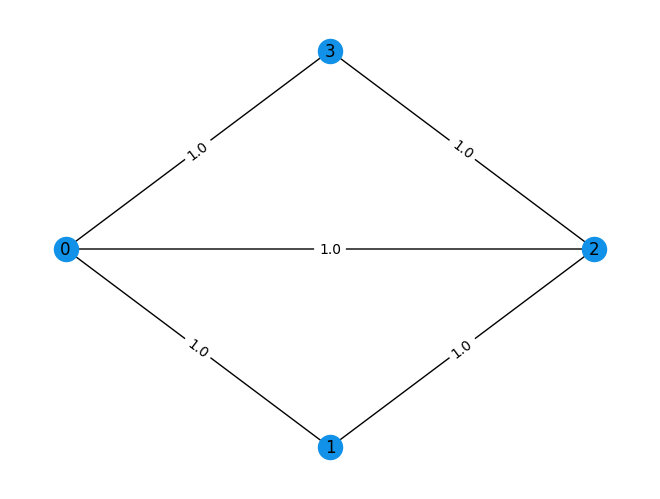

In [1]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw
 
n = 4
G = rx.PyGraph()
G.add_nodes_from(range(n))
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
G.add_edges_from(edges)
 
mpl_draw(
    G, pos=rx.shell_layout(G), with_labels=True, edge_labels=str, node_color="#1192E8"
)

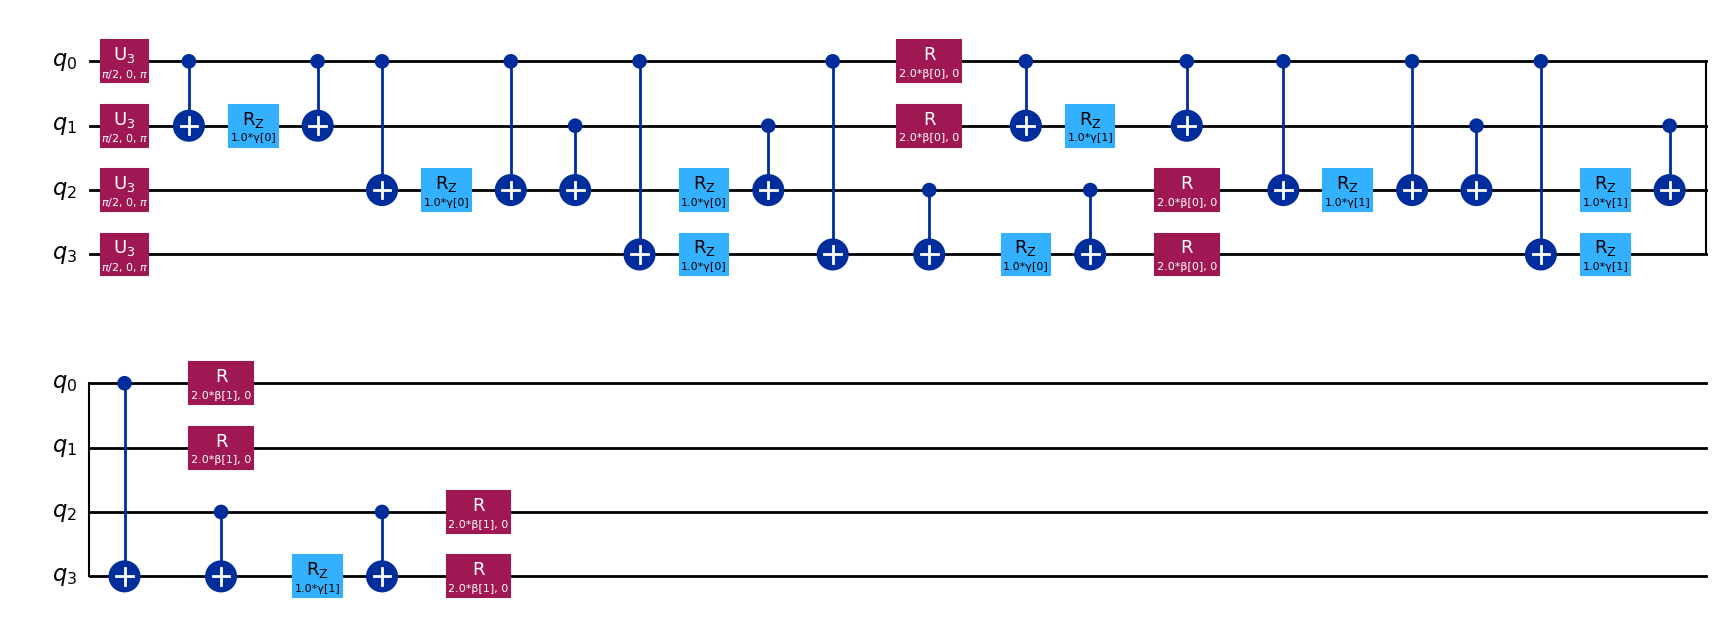

In [2]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
 
max_hamiltonian = SparsePauliOp.from_list(
    [("IIZZ", 0.5), ("IZIZ", 0.5), ("IZZI", 0.5), ("ZIIZ", 0.5), ("ZZII", 0.5)]
)
 
 
max_ansatz = QAOAAnsatz(max_hamiltonian, reps=2)
# Draw
max_ansatz.decompose(reps=3).draw("mpl")

In [3]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator
 
    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
 
    Returns:
        float: Energy estimate
    """
    pub = (max_ansatz, max_hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    #    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [4]:
# Sum the weights, and divide by 2
 
offset = -sum(edge[2] for edge in edges) / 2
print(f"""Offset: {offset}""")

Offset: -2.5


In [5]:
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.primitives import StatevectorSampler as Sampler
import numpy as np
 
estimator = Estimator()
sampler = Sampler()

 
x0 = 2 * np.pi * np.random.rand(max_ansatz.num_parameters)
print(x0)

[1.16893485 1.44175295 3.15244461 2.17040335]


In [6]:
from scipy.optimize import minimize

result = minimize(
    cost_func, x0, args=(max_ansatz, max_hamiltonian, estimator), method="COBYLA"
)

print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.3558363221647327
       x: [ 2.437e+00  1.243e+00  3.980e+00  3.567e+00]
    nfev: 92
   maxcv: 0.0


In [7]:
eigenvalue = cost_func(result.x, max_ansatz, max_hamiltonian, estimator)
print(f"""Eigenvalue: {eigenvalue}""")
print(f"""Max-Cut Objective: {eigenvalue + offset}""")

Eigenvalue: -1.3558363221647327
Max-Cut Objective: -3.8558363221647327


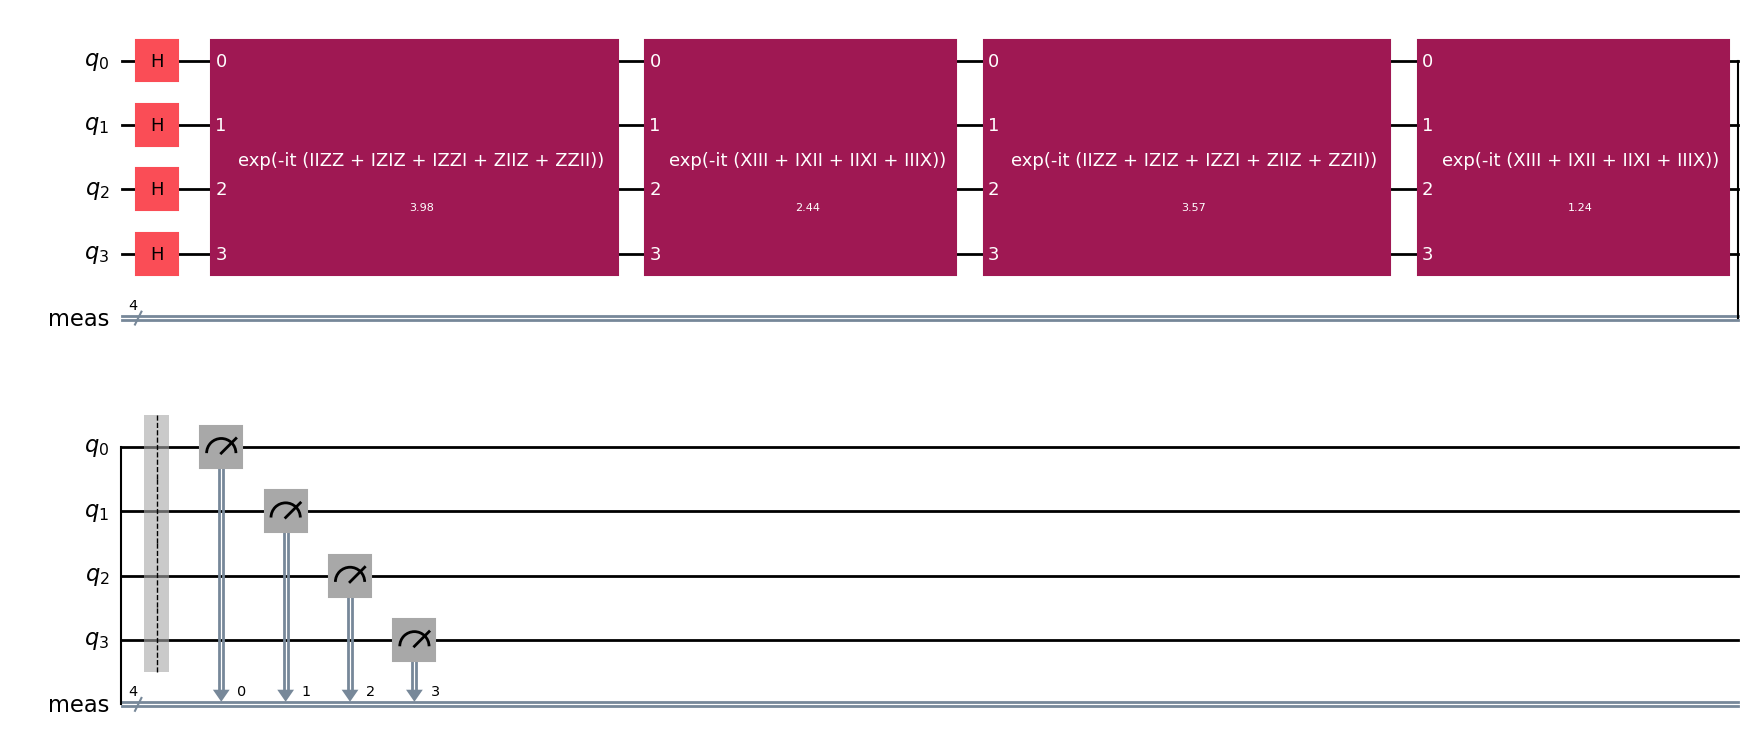

In [8]:
from qiskit.result import QuasiDistribution
from qiskit.primitives import StatevectorSampler
 
sampler = StatevectorSampler()
 
# Assign solution parameters to ansatz
qc = max_ansatz.assign_parameters(result.x)
 
# Add measurements to our circuit
qc.measure_all()
 
# Sample ansatz at optimal parameters
# samp_dist = sampler.run(qc).result().quasi_dists[0]
 
shots = 1024
job = sampler.run([qc], shots=shots)

qc.decompose().draw("mpl")

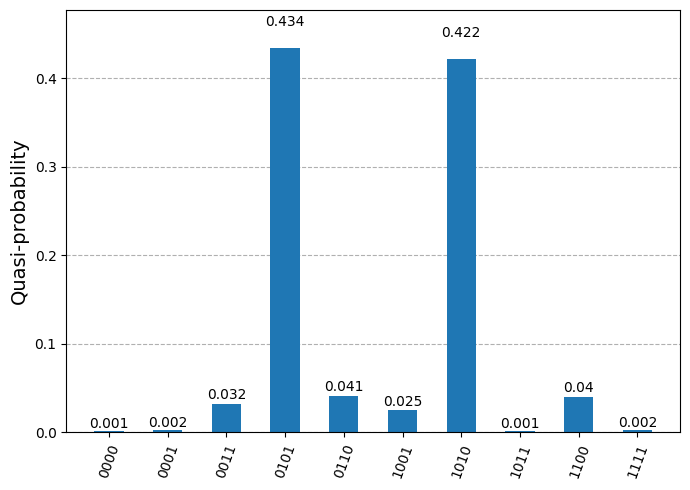

In [9]:
data_pub = job.result()[0].data
bitstrings = data_pub.meas.get_bitstrings()
counts = data_pub.meas.get_counts()
quasi_dist = QuasiDistribution(
    {outcome: freq / shots for outcome, freq in counts.items()}
)
probabilities = quasi_dist
 
# Close the session since we are now done with it
# session.close()

from qiskit.visualization import plot_distribution
 
plot_distribution(counts)

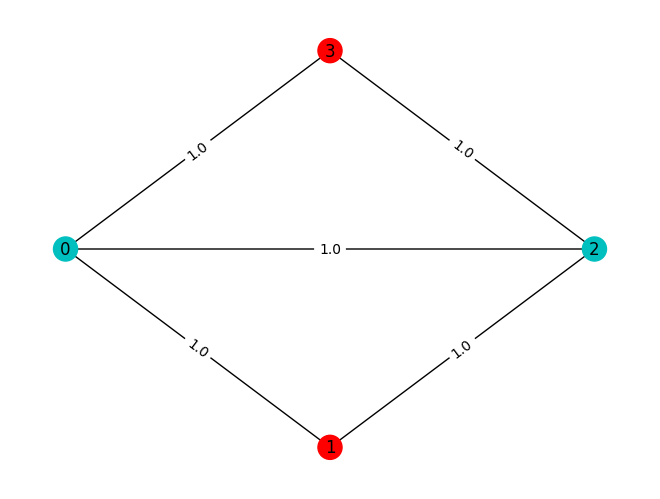

In [10]:
binary_string = max(counts.items(), key=lambda kv: kv[1])[0]
x = np.asarray([int(y) for y in reversed(list(binary_string))])
 
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
mpl_draw(
    G, pos=rx.shell_layout(G), with_labels=True, edge_labels=str, node_color=colors
)